Source: https://portal.tacc.utexas.edu/c/document_library/get_file?uuid=c2de5a2a-8e08-4f6e-8d49-2086681520d1&groupId=13601

In [1]:
import petsc4py, sys

import numpy as np
from petsc4py import PETSc
from matplotlib.pylab import plt
import numpy as np
%matplotlib inline

In [3]:
# grid size and spacing
m, n = 32, 32
hx = 1.0/(m-1)
hy = 1.0/(n-1)
# create sparse matrix
A = PETSc.Mat().create(PETSc.COMM_WORLD)
A.setSizes([m*n, m*n])
A.setFromOptions()
A.setUp()
#A.setType('aij') # sparse

In [4]:
# precompute values for setting
# diagonal and non-diagonal entries
diagv = 2.0/hx**2 + 2.0/hy**2
offdx = -1.0/hx**2
offdy = -1.0/hy**2

In [5]:
# loop over owned block of rows on this
# processor and insert entry values
Istart, Iend = A.getOwnershipRange()
for I in xrange(Istart, Iend) :
    A[I,I] = diagv
    i = I//n # map row number to
    j = I - i*n # grid coordinates
    if i> 0 : J = I-n; A[I,J] = offdx
    if i< m-1: J = I+n; A[I,J] = offdx
    if j> 0 : J = I-1; A[I,J] = offdy
    if j< n-1: J = I+1; A[I,J] = offdy

In [6]:
# communicate off-processor values
# and setup internal data structures
# for performing parallel operations
A.assemblyBegin()
A.assemblyEnd()

In [7]:
ksp = PETSc.KSP()
ksp.create(PETSc.COMM_WORLD)
ksp.setType('cg')

In [8]:
x, b = A.getVecs()
x.set(0.)

In [10]:
x, b = A.getVecs()
x.set(0)
b.set(1)

In [11]:
# and next solve
ksp.setOperators(A)
ksp.setFromOptions()
ksp.solve(b, x)

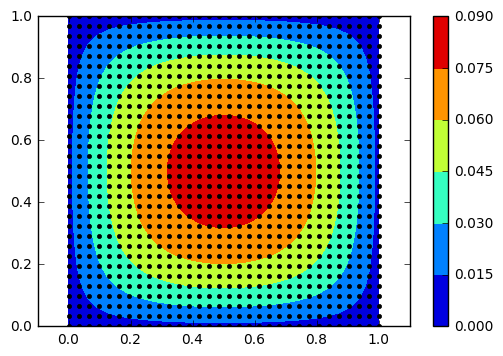

In [12]:
X, Y = np.mgrid[0:1:1j*m,0:1:1j*n]
Z = x[...].reshape(m,n)
plt.figure()
plt.contourf(X,Y,Z)
plt.plot(X.ravel(),Y.ravel(),'.k')
plt.axis('equal')
plt.colorbar()
plt.show()